In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [17]:
# Constants
T = 298 # Temperature [K]
F = 96485 # Faraday’s constant [C/mol]
R = 8.3145 # Gas constant [(C*V)/(mol*K)]
f = F/(R*T) # Reduced electrochemical parameter
C = 1.0 #  initial concentration of Ox [M]
D = 1E-6 # Diffusion coefficient [cm^2/s] {default: 1E-6}
v = 1E-3 # Scan rate [V/s] {default: 1E-3}
n = 1.0  # Number of electrons transferred during reaction {default: 1}
alpha = 0.5  # Transfer coefficient (unitless) {default: 0.5}
k0 = 1E-1 # Heterogeneous rate constant [m/s] {default: 1E-1}
kc = 1E-3 # Chemical rate constant [m/s] {default: 1E-3}

# Simulation Paramterers 
L = 500 # Number of time steps {default: 500}
DM = 0.45 # Model diffusion coefficient from problem. Default = 0.45
eta0 = 0.2 # Initial overpotential (relative to redox) [V] {default: 0.2}
etaF = -0.2 # Final overpotential (relative to redox) [V] {default: -0.2}

# Time paramaters 
k = np.array(list(range(0,L))) # time index vector
total_t  = 2*(eta0-etaF)/v # Maximum t value to simulate (1 CV)
del_t  = total_t/L # Time interval
t = del_t * k # Discretized t
ktk = kc*total_t   # Dimensionless kinetic parameter 
km = ktk/L # Normalized Dimensionless Kinetic parameter )
Lambda = k0/(D*f*v)**(0.5)  # Dimensionless Reversibility Parameter

# Mesh Point Parameters
del_x  = np.sqrt(D*del_t/DM) # x interval
npts_x = 100  # Number of mesh points {default: 100}

In [52]:
# PRE-INITIALIZATION 
C = C / 1000 # Convert C from mol/L to mol/cm3
eta1 = list(eta0 - v * t) # overpotential vector, negative scan
eta2 = list(etaF + v * t) # overpotential vector, positive scan
eta = np.asarray(eta1 + eta2) # Overpotential scane [V] 

Enorm = eta * f # normalized overpotential
kf = k0 *np.exp(-alpha * n * Enorm) # [=] cm/s, fwd rate constant (pg 799)
kb = k0 *np.exp((1-alpha) * n * Enorm) # [=] cm/s, rev rate constant (pg 799)

O = C*np.ones((L+1,npts_x)) # [=] mol/cm^3, concentration of O
R = np.zeros((L+1,npts_x))  # [=] mol/cm^3, concentration of R
Flux = np.zeros((1,L+1)) # [=] mol/cm^2-s, flux of O at the surface
Z = np.ones((1,L+1))

In [56]:
# START SIMULATION 
# j = time index. i = distance index
for j in range (1,L):
    # Update bulk concentrations of O and R
    for i in range(1,npts_x-1):
        O[j+1,i] = O[j,i] + DM*(O[j,i+1]+O[j,i-1]-2*O[j,i])
        R[j+1,i] = R[j,i] + DM*(R[j,i+1]+R[j,i-1]-2*R[j,i]) - km * R[j,i]

    if j == L:
        Flux[j] = Flux[j-1]
    else:
        # Update flux
        Flux[0,j+1] = (kf[j+1] * O[j+1,1] - kb[j+1] * R[j+1,1]) / (1 + del_x/D*(kf[j+1] + kb[j+1]))
    # Update surface concentrations
    O[j+1,0] = O[j+1,2] - Flux[0,j+1]*(del_x/D)
    R[j+1,0] = R[j+1,2] + Flux[0,j+1]*(del_x/D) - km*R[j+1,1]

# Calculate current density, Z, from flux of O
Z = -n *F * Flux * 1000 # [=] A/cm^2 -> mA/cm^2, current density


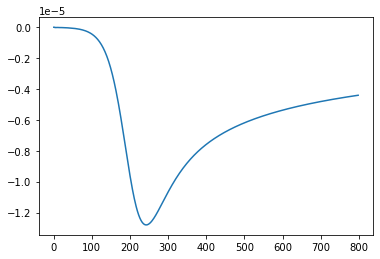

In [59]:
tlist = np.asarray(t)
Zlist = Z.flatten()
Znew = Zlist[0:-1]
plt.plot(t,Znew)